In [1]:
import numpy
import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Times New Roman"]})
plt.rcParams["font.family"] = "Times New Roman"

## Generic functions

In [2]:
def add_labels(graph_title, x_label, y_label):
    """Add labels to graphs"""
    plt.title(graph_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

## Papers

[Identifying elastoplastic parameters with Bayes’ theorem considering output error, input error and model uncertainty](https://www.sciencedirect.com/science/article/pii/S0266892018300547)

[A Tutorial on Bayesian Inference to Identify Material Parameters in Solid Mechanics](https://link.springer.com/article/10.1007/s11831-018-09311-x)

## Parameters

In [3]:
E_accurate = 210  # Young's modulus (GPa)
s_noise = 0.01  # Noise in the stress measurement (GPa)
stress_measured = [0.1576]
strain_measured = [7.25E-4]

## Bayes' Theorem

$$\pi(\textbf{x}|\textbf{y}) = \frac{\pi(\textbf{x})\pi(\textbf{y}|\textbf{x})}{\pi(\textbf{y})}$$

Where $\textbf{x}$ denotes a random vector with $n_p$ unknown parameters and $\textbf{y}$ denotes a random vector with $n_m$ measurements.

## Likelihood $\pi(\textbf{y}|\textbf{x})$

The PDF of the observed data $\textbf{y}$. To construct the likelihood function, a noise model has to be formulated and a noise distribution ($\pi_{noise}$) has to be determined. We assume that the noise distribution is known (including its parameters). The additive noise model can be written as follows:

$$\textbf{y} = \textbf{f}(\textbf{x}) + \Omega$$

Where $\textbf{x}$ denotes the vector with the unknown material parameters, $\textbf{y}$ the vector with the measured data and $\Omega$ is the noise vector. $\textbf{f}$ denotes the material description and is a function of the unknown material parameters ($\textbf{x}$).

$$\pi(\textbf{y}|\textbf{x}) = \pi_{noise}(\textbf{y} - \textbf{f}(\textbf{x}))$$

The only unknown material parameter in the linear elastic model is the Young's modulus ($E$). The additive noise measurement for a single stress measurement can be written as follows:

$$Y = E\epsilon + \Omega$$

Where $Y$ denotes the measured stress and $\Omega$ denotes the random variable representing the noise in the stress measurement. We consider the noise distribution to be normal (Gaussian) and hence, it can be written as:

$$\pi_{noise}(\omega) = \frac{1}{s_{noise}\sqrt{2\pi}}exp\left(-\frac{1}{2}{\frac{\omega}{s^2_{noise}}}\right)$$

## Prior distribution $\pi(E)$

The probability density function (PDF) that contains one's prior belief

We use a prior in the form of a modified normal distribution:

$$\pi(E) \propto exp\left(-\frac{(E - \overline{E})^2}{2s^2_E}\right) \quad \text{if}\; E \geqslant 0$$

In [4]:
def calculate_prior(E, mean, std_dev):
    tmp_1 = (E - mean)**2 / (2 * std_dev**2)
    prior = numpy.exp(-(tmp_1))
    return prior    

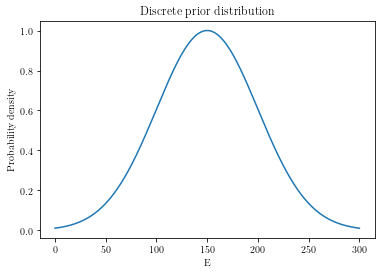

In [5]:
mean = 150.00  # GPa
std_dev = 50.00  # GPa
E_vector = numpy.linspace(0, 300.00, 10000)

prior_list = []

for i in range(len(E_vector)):
    E = E_vector[i]
    prior = calculate_prior(E, mean, std_dev)
    prior_list.append(prior)

plt.plot(E_vector, prior_list)
add_labels("Discrete prior distribution", "E", "Probability density")


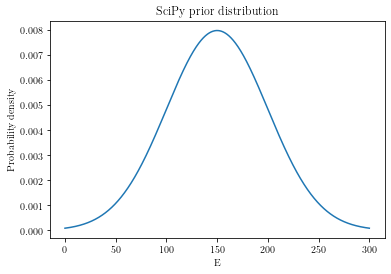

In [6]:
prior_scipy = scipy.stats.norm.pdf(E_vector, mean, std_dev)
plt.plot(E_vector, prior_scipy)
add_labels("SciPy prior distribution", "E", "Probability density")

## Posterior distribution $\pi(E|y)$

The PDF of the unknown parameters $\textbf{x}$, given the observations $\textbf{y}$

The posterior distribution for a single stress measurement reads:

$$\pi(E|y) \propto exp\left(-\left[\frac{(E - \overline{E})^2}{2s^2_E} + \frac{(y-E\epsilon)^2} {2s^2_{noise}}\right]\right) \quad \text{if}\; E \geqslant 0$$

Since the data $y$ is already measured, the denominator in Bayes' Theorem $\pi(y)$ is a positive constant number $C$. This constant number can be regarded as a normalisation factor that ensures that the integral of the posterior $\pi(E|y)$ over $E$ equals 1:

$$\pi(E|y) = \frac{1}{C}\pi(E)\pi(y|E)$$

In [7]:
def calculate_posterior(E, mean, std_dev, stress, strain, std_dev_noise):
    tmp_1 = (E - mean)**2 / (2 * std_dev**2)
    tmp_2 = 0
    for i in range(len(stress)):
        tmp_2 += (stress[i] - E*strain[i])**2 
    tmp_2 /= (2 * std_dev_noise**2)
    posterior = numpy.exp(-(tmp_1 + tmp_2))
    return posterior    

## Stress-strain graph - one measurement

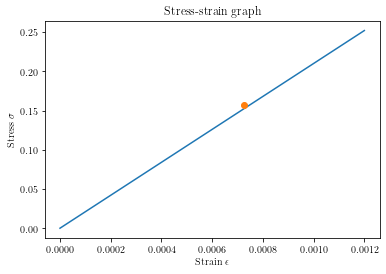

In [8]:
strain = numpy.linspace(0, 1.2E-3)
stress = E_accurate * strain

plt.plot(strain, stress)
plt.plot(strain_measured, stress_measured, 'o')
add_labels("Stress-strain graph", "Strain $\epsilon$", "Stress $\sigma$")

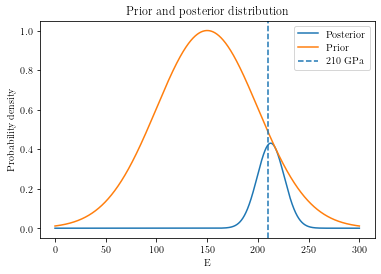

In [9]:
posterior_list = []

for i in range(len(E_vector)):
    E = E_vector[i]
    posterior = calculate_posterior(E, mean, std_dev, stress_measured, strain_measured, s_noise)
    posterior_list.append(posterior)

plt.plot(E_vector, posterior_list, label='Posterior')
plt.plot(E_vector, prior_list, label='Prior')
plt.axvline(x=E_accurate, label='210 GPa', linestyle='--')
plt.legend()
add_labels("Prior and posterior distribution", "E", "Probability density")

In [10]:
posterior_integral = numpy.trapz(posterior_list, E_vector)
prior_integral = numpy.trapz(prior_list, E_vector)
print('Integral of the posterior =', posterior_integral)
print('Integral of the prior =', prior_integral)

Integral of the posterior = 14.334268470159387
Integral of the prior = 124.99304437415378


### Normalise

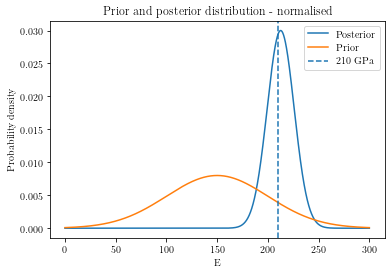

In [11]:
plt.plot(E_vector, numpy.asarray(posterior_list) * (1 / posterior_integral), label='Posterior')
plt.plot(E_vector, numpy.array(prior_list) * (1 / prior_integral), label='Prior')
plt.axvline(x=E_accurate, label='210 GPa', linestyle='--')
plt.legend()
add_labels("Prior and posterior distribution - normalised", "E", "Probability density")

## Stress-strain graph - ten measurements

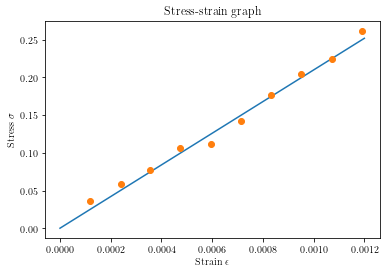

In [12]:
stress_measured = [0.0357, 0.0585, 0.0767, 0.1059, 0.1123, 
                   0.1423, 0.1773, 0.2046, 0.2251, 0.2623]
strain_measured = [0.1168E-3, 0.2400E-3, 0.3568E-3, 0.4747E-3, 0.5935E-3, 
                   0.7124E-3, 0.8303E-3, 0.9503E-3, 1.0724E-3, 1.1924E-3]

plt.plot(strain, stress)
plt.plot(strain_measured, stress_measured, 'o')
add_labels("Stress-strain graph", "Strain $\epsilon$", "Stress $\sigma$")


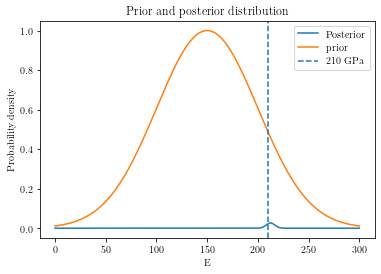

In [13]:
posterior_list = []

for i in range(len(E_vector)):
    E = E_vector[i]
    posterior = calculate_posterior(E, mean, std_dev, stress_measured, strain_measured, s_noise)
    posterior_list.append(posterior)

plt.plot(E_vector, posterior_list, label='Posterior')
plt.plot(E_vector, prior_list, label='prior')
plt.axvline(x=E_accurate, label='210 GPa', linestyle='--')
plt.legend()
add_labels("Prior and posterior distribution", "E", "Probability density")

In [14]:
posterior_integral = numpy.trapz(posterior_list, E_vector)
print('Integral of the posterior =', posterior_integral)

Integral of the posterior = 0.28455275971026794


### Normalise

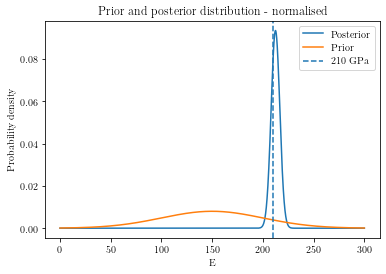

In [15]:
plt.plot(E_vector, numpy.asarray(posterior_list) * (1 / posterior_integral), label='Posterior')
plt.plot(E_vector, numpy.array(prior_list) * (1 / prior_integral), label='Prior')
plt.axvline(x=E_accurate, label='210 GPa', linestyle='--')
plt.legend()
add_labels("Prior and posterior distribution - normalised", "E", "Probability density")